In [1]:
import warnings; warnings.simplefilter('ignore')      # 忽略警告信息；
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
# from scipy.stats import norm
from matplotlib import pyplot as plt
from tqdm import *

## Predict reinvest decisions

In [2]:
df = pd.read_csv('training_data.csv')
del df['Unnamed: 0']

In [ ]:
df['value_chg'] = (df['value_chg'] - df['value_chg'].min()) / (df['value_chg'].max() - df['value_chg'].min())
df['percent_total'] = (df['percent_total'] - df['percent_total'].min()) / (df['percent_total'].max() - df['percent_total'].min())

In [3]:
choose_factor = [i for i in df.columns if i in ['rounds','percent_total','value_chg','follow_count','industry_level',
                                                 'industry_code','investor_count','founder_count','male_ratio','rate']]

In [4]:
choose_feature = df[choose_factor]
choose_label = df['label']

In [5]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X_resampled_smote, y_resampled_smote = SMOTE().fit_resample(choose_feature, choose_label)
print(sorted(Counter(y_resampled_smote).items()))

[(0, 5536), (1, 5536)]


In [6]:
df['investor_name'] = df['first_name'].apply(str) + df['last_name'].apply(str) 
compy_name = df['Company name'].unique().tolist()
invstr_name = df['investor_name'].unique().tolist()
ddd = pd.DataFrame()

In [7]:
for compy in tqdm(compy_name):
    for invt in invstr_name:
        dd = df[(df['Company name'] == compy)&(df.investor_name == invt)]
        dd = dd.sort_values(by='rounds')
        try:
            dd['percent_total_1'] = dd['percent_total'].values[0]
            ddd = pd.concat([ddd,dd],axis=0)
#             print(ddd.head(2))
        except:
            continue

100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [09:49<00:00,  7.19s/it]


In [8]:
data = ddd.copy()

In [9]:
data['percent_total'] = data['percent_total_1']

In [10]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

X_train,X_test,y_train,y_test = train_test_split(choose_feature, choose_label,test_size=0.3,random_state=1,stratify=choose_label)
clf_forest = RandomForestClassifier(n_estimators=10, max_features='sqrt', max_depth=100, class_weight='balanced')
clf_forest.fit(X_train,y_train)
predict = clf_forest.predict(X_test)
print(sm.classification_report(y_test,predict))

precision = precision_score(y_test,predict)
print("precision: %.3f%%" % (precision*100.0))

In [ ]:
# print the importance of features
importances = clf_forest.feature_importances_ 
importances_df = pd.DataFrame([choose_factor, importances], index=['Features', 'Importances']).T
importances_df.sort_values(by='Importances',ascending=False).head(10)

In [ ]:
importances_df.set_index('Features').sort_values(by='Importances',ascending=False).head(10).plot.bar(figsize=(14,6),title='Feature Importance')

In [12]:
data['predict_label'] = clf_forest.predict(data[choose_factor])

In [13]:
data.columns

Index(['Company name', 'filing_date', 'total_shares', 'round_shares', 'rounds',
       'first_name', 'last_name', 'number_of_shares', 'percent_total',
       'Deal date', 'Investment amount', 'Incorporation date', 'Current stage',
       'Exit date', 'Exit price', 'investor_count', 'male', 'female',
       'founder_count', 'exit_shares', 'add_shares', 'follow', 'valuation',
       'first_industry', 'value_chg', 'follow_count', 'rate', 'industry_val',
       'mean_val', 'industry_level', 'industry_code', 'male_ratio', 'label',
       'investor_name', 'percent_total_1', 'predict_label'],
      dtype='object')

In [14]:
data['paid_in_once'] = data['round_shares']*data['valuation']*data['percent_total']

In [15]:
data_add_paidin = pd.DataFrame()

In [16]:
for compy in tqdm(compy_name):
    for invt in invstr_name:
        dd = data[(data['Company name'] == compy)&(data.investor_name == invt)]
        dd = dd.sort_values(by='rounds')
        dd['paid_in'] = dd['paid_in_once'].cumsum()
        data_add_paidin = pd.concat([data_add_paidin,dd],axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [45:58<00:00, 33.64s/it]


In [17]:
data_add_paidin.to_csv('data_add_paidin.csv')

## import data_add_paidin.csv

In [18]:
data_add_paidin = pd.read_csv('data_add_paidin.csv')
del data_add_paidin['Unnamed: 0']

In [19]:
data_add_paidin.columns

Index(['Company name', 'filing_date', 'total_shares', 'round_shares', 'rounds',
       'first_name', 'last_name', 'number_of_shares', 'percent_total',
       'Deal date', 'Investment amount', 'Incorporation date', 'Current stage',
       'Exit date', 'Exit price', 'investor_count', 'male', 'female',
       'founder_count', 'exit_shares', 'add_shares', 'follow', 'valuation',
       'first_industry', 'value_chg', 'follow_count', 'rate', 'industry_val',
       'mean_val', 'industry_level', 'industry_code', 'male_ratio', 'label',
       'investor_name', 'percent_total_1', 'predict_label', 'paid_in_once',
       'paid_in'],
      dtype='object')

## Always Follow-on
### Involve in every funding round until the company Dead/M&A/IPO.

In [20]:
temp = data_add_paidin.drop_duplicates(subset=['Company name','investor_name'], keep='last', inplace=False) 

In [21]:
temp['tvpi'] = temp['percent_total'] * temp['Exit price']/temp['paid_in']

In [22]:
always = pd.merge(data_add_paidin,temp[['Company name','investor_name','tvpi']],on=['Company name','investor_name'],how='outer')

In [23]:
always.to_csv(r'always_tvpi.csv')

In [24]:
always = always.dropna()

In [25]:
always_mean = np.mean(always['tvpi'].values.tolist())
always_median = np.median(always['tvpi'].values.tolist())
print('always_mean =',always_mean)
print('always_median =',always_median)

always_mean = 0.39537069755379417
always_median = 0.0


In [26]:
always['tvpi'].value_counts()

0.000000     2185
9.331895       34
7.260005       27
0.431035       12
9.331895        6
7.260005        6
32.699423       3
12.164524       3
7.260005        3
18.663790       3
18.246786       2
9.331895        2
18.663790       1
Name: tvpi, dtype: int64

<AxesSubplot:xlabel='tvpi', ylabel='Density'>

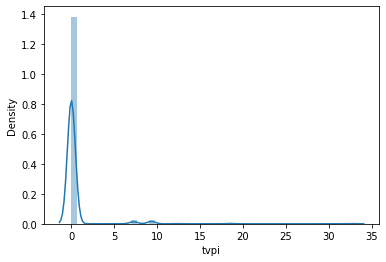

In [27]:
sns.distplot(always['tvpi'])

## Never Follow-on
### Only involve in the first funding round.

In [41]:
never = always.drop_duplicates(subset=['Company name','last_name','first_name'], keep='first', inplace=False)

In [42]:
never['tvpi'] = never['percent_total']*never['Exit price']/never['paid_in_once']

In [43]:
never_mean = np.mean(never['tvpi'].values.tolist())
never_median = np.median(never['tvpi'].values.tolist())
print('never_mean =',never_mean)
print('never_median =',never_median)

never_mean = 0.963019235410572
never_median = 0.0


In [44]:
never['tvpi'].value_counts()

0.000000     1030
18.663790      22
32.699423      15
1.724140        3
18.663790       2
18.663790       1
36.493572       1
36.493572       1
Name: tvpi, dtype: int64

<AxesSubplot:xlabel='tvpi', ylabel='Density'>

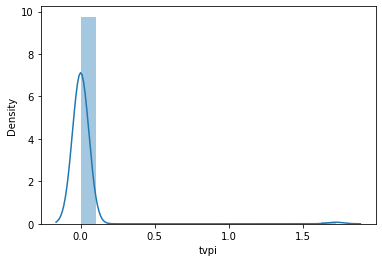

In [32]:
sns.distplot(never['tvpi'])

## Follow-on according to the model predictions
### Involve in subsequent rounds until the prediction output is ‘not follow-on’(label=0)

In [33]:
# always['rounds'].unique().tolist()

In [34]:
# always['predict_label']

In [35]:
predict = always
length_column = predict.shape[0]

for i in tqdm(range(0,length_column)):
    if (predict['Company name'].iloc[i] == predict['Company name'].iloc[i-1])&(predict['investor_name'].iloc[i] == predict['investor_name'].iloc[i-1]):
        predict['predict_label'].iloc[i] = predict['predict_label'].iloc[i]*predict['predict_label'].iloc[i-1]
    else:
        predict['predict_label'].iloc[i] = 1

100%|████████████████████████████████████████████████████████████████████████████| 2287/2287 [00:01<00:00, 1768.76it/s]


In [36]:
# predict.info()

In [37]:
predict['add_shares'] = predict['percent_total'] * predict['round_shares'] * predict['predict_label']
predict['paid_in_each'] = predict['add_shares'] * predict['valuation']

In [38]:
predict['paid_in_add']=''
length_column = predict.shape[0]
for i in tqdm(range(0,length_column)):
    if (predict['Company name'].iloc[i] == predict['Company name'].iloc[i-1])&(predict['investor_name'].iloc[i] == predict['investor_name'].iloc[i-1]):
        predict['number_of_shares'].iloc[i] = predict['number_of_shares'].iloc[i-1] + predict['add_shares'].iloc[i]
        predict['paid_in_add'].iloc[i] = predict['paid_in_add'].iloc[i-1] + predict['paid_in_each'].iloc[i]
    else:
        predict['number_of_shares'].iloc[i] = predict['add_shares'].iloc[i]
        predict['paid_in_add'].iloc[i] = predict['paid_in_each'].iloc[i]    

100%|█████████████████████████████████████████████████████████████████████████████| 2287/2287 [00:02<00:00, 950.15it/s]


In [39]:
predict['tvpi'] = ((predict['number_of_shares'] / predict['total_shares']) * predict['Exit price']) / predict['paid_in_add']

In [40]:
predict_mean = np.mean(predict['tvpi'].values.tolist())
predict_median = np.median(predict['tvpi'].values.tolist())
print('predict_mean =',predict_mean)
print('predict_median =',predict_median)

predict_mean = 0.5094873376329077
predict_median = 0.0


In [45]:
predict['tvpi'].value_counts()

0.000000     2185
7.280746       17
32.679959      14
7.272611       10
11.864366      10
7.272611        9
11.877637       9
7.280746        4
0.020853        3
0.574713        2
7.272611        2
1.724140        2
0.862070        2
11.877637       2
0.097638        1
0.431035        1
1.724140        1
0.574713        1
7.280746        1
11.864366       1
11.877637       1
0.431035        1
0.862070        1
0.098101        1
11.864366       1
32.679959       1
36.085710       1
18.043403       1
12.029575       1
0.431035        1
Name: tvpi, dtype: int64

<AxesSubplot:xlabel='tvpi', ylabel='Density'>

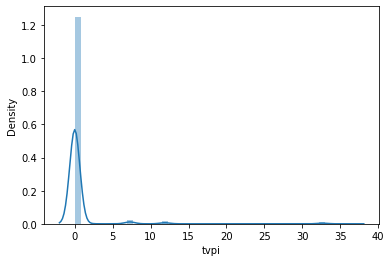

In [46]:
sns.distplot(predict['tvpi'])